[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pablo-sampaio/rl_facil/blob/main/cap07/cap07-main.ipynb)

# Capítulo 7 - Algoritmos com Modelo


## Configurações Iniciais

In [1]:
from IPython.display import clear_output
import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # for saving videos
    !apt-get install ffmpeg #freeglut3

    !pip install gymnasium
    !pip install optuna

    # clone repository
    !git clone https://github.com/pablo-sampaio/rl_facil
    sys.path.append("/content/rl_facil")

else:
    from os import path
    sys.path.append( path.dirname( path.dirname( path.abspath("__main__") ) ) )

#clear_output()

In [2]:
'''if IN_COLAB:
    # Set up fake display; otherwise rendering will fail
    import os
    os.system("Xvfb :1 -screen 0 1024x768x24 &")
    os.environ['DISPLAY'] = ':1'

    from util.notebook import display_videos_from_path'''

'if IN_COLAB:\n    # Set up fake display; otherwise rendering will fail\n    import os\n    os.system("Xvfb :1 -screen 0 1024x768x24 &")\n    os.environ[\'DISPLAY\'] = \':1\'\n\n    from util.notebook import display_videos_from_path'

In [3]:
import random as rand
import gymnasium as gym
import numpy as np

from util.experiments import repeated_exec
from util.plot import plot_result, plot_multiple_results
from util.notebook import display_videos_from_path

from util.qtable_helper import evaluate_qtable, record_video_qtable

In [4]:
from gymnasium.envs import register

#from envs import RacetrackEnv

register(
    id='Racetrack',  # Use a unique string ID for your environment
    entry_point='envs:RacetrackEnv',  # Specify the module and class name
    max_episode_steps=300,
)


## 1 - Q-Learning

O *Q-Learning* é um algoritmo **livre de modelo**, mas estamos relembrando aqui, primeiramente, com o **desempenho** do do próximo algoritmo´.

Também recomendamos relembrar o **código** do Q-Learning, pois o Dyna-Q é um extensão simples dele.

Ambos os algoritmos serão executados (em um teste simples) com o ambiente e os parâmetros dados abaixo.

In [5]:
# escolha o ambiente descomentando uma das linhas abaixo
#ENV_NAME = 'Taxi-v3'
ENV_NAME = 'Racetrack'

LR = 0.3
GAMMA = 0.90
EPSILON = 0.1

#VERBOSE = True

In [6]:
from cap05.qlearning_sarsa import run_qlearning

In [7]:
if ENV_NAME == "Taxi-v3":
    rmax = 10.0
    env = gym.make("Taxi-v3")
    EPISODES = 700
else:
    rmax = 0.0
    env = gym.make("Racetrack")
    EPISODES = 3_000

rewards1, qtable1 = run_qlearning(env, EPISODES, LR, GAMMA, EPSILON)
print("Últimos resultados: media =", np.mean(rewards1[-20:]), ", desvio padrao =", np.std(rewards1[-20:]))

Últimos resultados: media = -66.05 , desvio padrao = 57.920182147503645


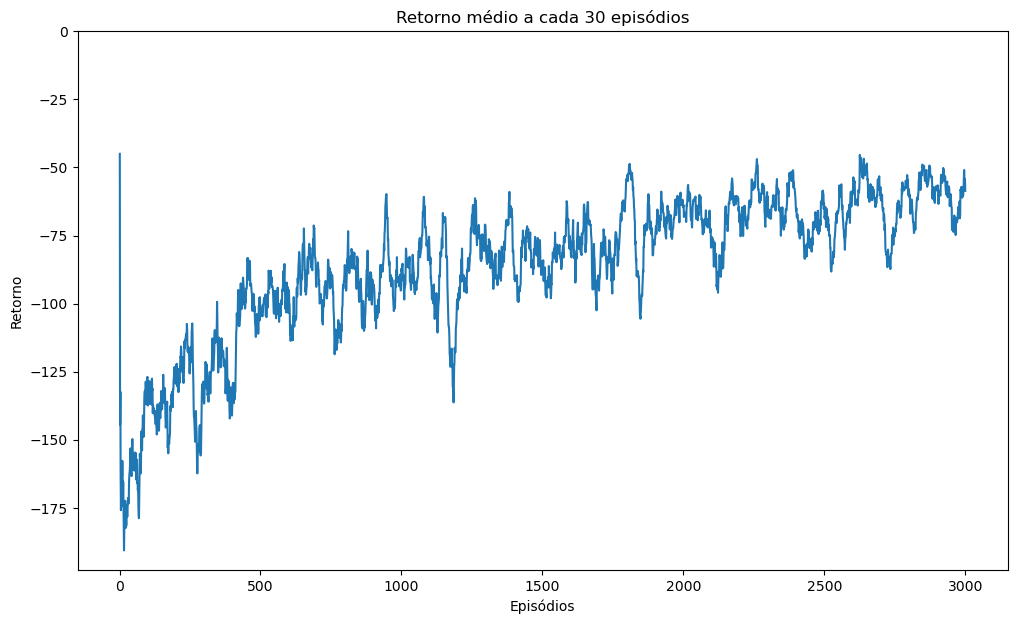

In [8]:
# Mostra um gráfico de passos x retornos não descontados acumulados
plot_result(rewards1, rmax, cumulative=False, window=30)

In [9]:
evaluate_qtable(env, qtable1, 10, verbose=True);

Episódio 1: -300.0
Episódio 2: -300.0
Episódio 3: -14.0
Episódio 4: -29.0
Episódio 5: -14.0
Episódio 6: -31.0
Episódio 7: -14.0
Episódio 8: -300.0
Episódio 9: -300.0
Episódio 10: -300.0
Retorno médio (por episódio): -160.2, episódios: 10, total de passos: 1607


In [10]:
record_video_qtable(env, qtable1, length=500, folder='./videos-qlearn')

c:\ProgramData\anaconda3\envs\rl23\lib\site-packages\gymnasium\wrappers\record_video.py:87: UserWarning: WARN: Overwriting existing videos at d:\Pablo\Documents\Projects\pablo-sampaio\rl_facil\cap07novo\videos-qlearn folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video d:\Pablo\Documents\Projects\pablo-sampaio\rl_facil\cap07novo\videos-qlearn\rl-video-episode-0.mp4.
Moviepy - Writing video d:\Pablo\Documents\Projects\pablo-sampaio\rl_facil\cap07novo\videos-qlearn\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready d:\Pablo\Documents\Projects\pablo-sampaio\rl_facil\cap07novo\videos-qlearn\rl-video-episode-0.mp4


In [11]:
display_videos_from_path('./videos-qlearn', speed=0.5)

## 2 - Dyna-Q

O *Dyna-Q* é um algoritmo **com modelo** que é uma extensão do *Q-Learning*. Compare os códigos para entender o Dyna-Q.

In [12]:
def planning(model, planning_steps, Q, lr, gamma):
    all_s_a = list(model.keys())
    if len(all_s_a) < planning_steps:
        samples = rand.choices(all_s_a, k=planning_steps)
    else:
        samples = rand.sample(all_s_a, k=planning_steps)

    for s, a in samples:
        r, next_s, is_terminal = model[(s,a)]
        if is_terminal:
            V_next_s = 0
        else:
            V_next_s = np.max(Q[next_s])
        delta = (r + gamma * V_next_s) - Q[s,a]
        Q[s,a] = Q[s,a] + lr * delta

In [13]:
# Esta é a política. Neste caso, escolhe uma ação com base nos valores da tabela Q, usando uma estratégia epsilon-greedy, 
# dividindo a probabilidade igualmente em caso de empates entre ações de valor máximo.
from util.qtable_helper import epsilon_greedy_random_tiebreak

In [14]:
# Algoritmo Dyna Q
def run_dyna_q(env, episodes, lr=0.1, gamma=0.95, epsilon=0.1, planning_steps=5):
    assert isinstance(env.observation_space, gym.spaces.Discrete)
    assert isinstance(env.action_space, gym.spaces.Discrete)

    num_actions = env.action_space.n

    # inicializa a tabela Q
    Q = np.zeros(shape=(env.observation_space.n, num_actions))

    model = dict({})

    # para cada episódio, guarda sua soma de recompensas (retorno não-descontado)
    sum_rewards_per_ep = []

    # loop principal
    for i in range(episodes):
        done = False
        sum_rewards, reward = 0, 0

        state, _ = env.reset()

        # executa 1 episódio completo, fazendo atualizações na Q-table
        while not done:

            # escolhe a próxima ação -- usa epsilon-greedy
            action = epsilon_greedy_random_tiebreak(Q, state, epsilon)

            # realiza a ação, ou seja, dá um passo no ambiente
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            if terminated:
                # para estados terminais
                V_next_state = 0
                next_state = env.reset()
            else:
                # para estados não-terminais -- valor máximo (melhor ação)
                V_next_state = np.max(Q[next_state])

            # atualiza a Q-table / direct RL
            delta = (reward + gamma * V_next_state) - Q[state,action]
            Q[state,action] = Q[state,action] + lr * delta

            # atualiza o modelo
            model[state,action] = (reward, next_state, done)

            # planejamento / indirect RL
            planning(model, planning_steps, Q, lr, gamma)

            sum_rewards += reward
            state = next_state

        sum_rewards_per_ep.append(sum_rewards)

        # a cada 1000 passos, imprime informação sobre o progresso
        if VERBOSE and ((i+1) % 1000 == 0):
            avg_reward = np.mean(sum_rewards_per_ep[-100:])
            print(f"Step {i+1} Average Reward (last 100): {avg_reward:.3f}")

    state = env.reset()
    reward = 0

    return sum_rewards_per_ep, Q

In [15]:
env = gym.make(ENV_NAME)

if ENV_NAME == 'Taxi-v3':
    rmax = 10.0
    EPISODES = 700
else:
    rmax = 0.0
    EPISODES = 3_000

rewards2, qtable2 = run_dyna_q(env, EPISODES, LR, GAMMA, EPSILON, planning_steps=10)
print("Últimos resultados: media =", np.mean(rewards2[-20:]), ", desvio padrao =", np.std(rewards2[-20:]))

NameError: name 'VERBOSE' is not defined

In [ ]:
# Mostra um gráfico de passos x retornos não descontados acumulados
plot_result(rewards2, rmax, cumulative='no', window=30)

In [ ]:
evaluate_qtable(env, qtable2, 10, verbose=True);

In [ ]:
record_video_qtable(env, qtable2, length=500, folder='./videos-dynaq')

In [ ]:
display_videos_from_path('./videos-dynaq', speed=0.5)

## 3 - Experimentos com "Taxi-v3" (ou o "Racetrack")

Nesta seção, você pode fazer experimentos no `Taxi-v3` ou no `Racetrack`, como preferir. Porém, sabia que o treinamento com Racetrack é bem mais demorado.

Escolha o ambiente na célula de código abaixo.

Os experimentos têm duas partes:
- Na seção 3.1, vamos otimizar os parâmetros do Q-Learning
- Na seção 3.2, vamos rodar o Q-Learning e o Dyna-Q (ambos com os parâmetros do Q-Learning), para comparar


In [ ]:
# Escolha abaixo o ambiente
ENV_NAME_EXPERIMENT = 'Taxi-v3'
#ENV_NAME_EXPERIMENT = 'Racetrack'

### 3.1 - Otimizando Parâmetros do Q-Learning

In [ ]:
import optuna

In [ ]:
if ENV_NAME_EXPERIMENT == 'Taxi-v3':
    EPISODES_PER_TRIAL = 200
else:
    EPISODES_PER_TRIAL = 800

RUNS_PER_TRIAL = 3

In [ ]:
def train(trial : optuna.Trial):
    # chama os métodos do "trial" (tentativa) para sugerir valores para os parâmetros
    lr = trial.suggest_uniform('lr', 0.1, 1.0)
    eps = trial.suggest_uniform('epsilon', 0.01, 0.2)
    gamma = trial.suggest_uniform('gamma', 0.5, 1.0)

    print(f"\nTRIAL #{trial.number}: lr={lr}, eps={eps}, gamma={gamma}")

    # roda o algoritmo várias vezes
    global RUNS_PER_TRIAL, EPISODES_PER_TRIAL
    
    env = gym.make(ENV_NAME_EXPERIMENT)
    results = repeated_exec(RUNS_PER_TRIAL, "qlearn-optuna", run_qlearning, env, EPISODES_PER_TRIAL, lr=lr, epsilon=eps, gamma=gamma)

    # soma dos retornos não-descontado finais (dos últimos 20 episódios)
    return np.sum(results[1][:,-20:])

In [ ]:
study = optuna.create_study(direction='maximize',
                        storage='sqlite:///optuna_planning.db',
                        study_name=f'qlearning_{ENV_NAME_EXPERIMENT}',
                        load_if_exists=True)

study.optimize(train, n_trials=30)
clear_output()

print(f"MELHORES PARÂMETROS PARA {ENV_NAME_EXPERIMENT}:")
print(study.best_params)
qlearn_params_taxi = study.best_params

### 3.2 - Experimentos Comparativos

In [ ]:
environment = gym.make(ENV_NAME_EXPERIMENT)

if ENV_NAME_EXPERIMENT == 'Taxi-v3':
    EPISODES = 1000
    RUNS  = 5
else:
    EPISODES = 4_000
    RUNS = 3

AUTO_LOAD = True

results_t = []

results_t.append( repeated_exec(RUNS, f"Q-Learning ", run_qlearning, environment, EPISODES, **qlearn_params_taxi, auto_load=AUTO_LOAD) )
clear_output()

#plan_steps = 1
#results_t.append( repeated_exec(RUNS, f"Dyna-Q ({plan_steps} passo)", run_dyna_q, environment, EPISODES, **qlearn_params_taxi, planning_steps=plan_steps, auto_load=AUTO_LOAD) )
#clear_output()

plan_steps = 10
results_t.append( repeated_exec(RUNS, f"Dyna-Q ({plan_steps} passos)", run_dyna_q, environment, EPISODES, **qlearn_params_taxi, planning_steps=plan_steps, auto_load=AUTO_LOAD) )
clear_output()


In [ ]:
plot_multiple_results(results_t, cumulative='avg', x_log_scale=False)

In [ ]:
plot_multiple_results(results_t, cumulative='no', x_log_scale=False, window=100)

## 4 - Experimentos com "FrozenLake-v1"

Nesta seção, vamos fazer experimentos similares aos da seção 3, mas focando no ambiente `FrozenLake`.

Este ambiente tem como diferencial o fato de ser **não-determinístico**:
- uma ação tem 1/3 de chance de dar o resultado correto
- e 1/3 de fazer o agente mover em cada direção perpendicular à desejada.

Isso afeta um pouco os resultados, como veremos.

### 4.1 - Otimizando Parâmetros do Q-Learning

In [ ]:
# Ao setar as variáveis abaixo, a função 'train' vai servir para a otimização neste ambiente
ENV = gym.make("FrozenLake-v1")
RUNS_PER_TRIAL = 7
EPISODES_PER_TRIAL = 1_000

In [ ]:
study = optuna.create_study(direction='maximize',
                        storage='sqlite:///optuna_planning.db',
                        study_name=f'qlearning_frozen',
                        load_if_exists=True)

study.optimize(train, n_trials=50)
clear_output()

print("MELHORES PARÂMETROS:")
print(study.best_params)
qlearn_params_frozen = study.best_params

### 4.2 - Experimentos Comparativos

In [ ]:
environment = gym.make("FrozenLake-v1")
EPISODES = 7_000
RUNS = 20
AUTO_LOAD = True

results_f = []

results_f.append( repeated_exec(RUNS, f"Q-Learning ", run_qlearning, environment, EPISODES, **qlearn_params_frozen, auto_load=AUTO_LOAD) )
clear_output()

#plan_steps = 1
#results_f.append( repeated_exec(RUNS, f"Dyna-Q ({plan_steps} passo)", run_dyna_q, environment, EPISODES, **qlearn_params_frozen, planning_steps=plan_steps, auto_load=AUTO_LOAD) )
#clear_output()

plan_steps = 5
results_f.append( repeated_exec(RUNS, f"Dyna-Q ({plan_steps} passo)", run_dyna_q, environment, EPISODES, **qlearn_params_frozen, planning_steps=plan_steps, auto_load=AUTO_LOAD) )
clear_output()

In [ ]:
plot_multiple_results(results_f, cumulative='avg', x_log_scale=False)

In [ ]:
plot_multiple_results(results_f, cumulative='no', x_log_scale=False, window=100)

## 5 - Desafio

O Dyna-Q foi bem no ambiente `FrozenLake-v1`?

Apesar de variar entre execuções, ele não costuma ser muito bom para quantidades altas de "passos de planejamento".

**Você acha que isso aconteceu por qual motivo?**

Proponha uma modificação simples no *modelo* e no *planejamento* do Dyna-Q para melhorar o desempenho dele nesse ambiente.

Depois, refaça os experimentos da seção 4.2 para conferir se deu certo.

In [ ]:
def planning_new(model, planning_steps, Q, lr, gamma):
    # altere aqui !!!
    pass

In [ ]:
# Algoritmo Dyna Q
def run_dyna_q_new(env, episodes, lr=0.1, gamma=0.95, epsilon=0.1, planning_steps=5):
    assert isinstance(env.observation_space, gym.spaces.Discrete)
    assert isinstance(env.action_space, gym.spaces.Discrete)

    num_actions = env.action_space.n

   # inicializa a tabela Q
    Q = np.zeros(shape=(env.observation_space.n, num_actions))

    model = dict({})

    # para cada episódio, guarda sua soma de recompensas (retorno não-descontado)
    sum_rewards_per_ep = []

    # loop principal
    for i in range(episodes):
        done = False
        sum_rewards, reward = 0, 0

        state = env.reset()

        # executa 1 episódio completo, fazendo atualizações na Q-table
        while not done:

            # escolhe a próxima ação -- usa epsilon-greedy
            action = epsilon_greedy_random_tiebreak(Q, state, epsilon)

            # realiza a ação, ou seja, dá um passo no ambiente
            next_state, reward, done, _ = env.step(action)

            if done:
                # para estados terminais
                V_next_state = 0
                next_state = env.reset()
            else:
                # para estados não-terminais -- valor máximo (melhor ação)
                V_next_state = np.max(Q[next_state])

            # atualiza a Q-table / direct RL
            delta = (reward + gamma * V_next_state) - Q[state,action]
            Q[state,action] = Q[state,action] + lr * delta

            # atualiza o modelo
            # ALTERE AQUI !!!

            # planejamento / indirect RL
            planning_new(model, planning_steps, Q, lr, gamma)

            sum_rewards += reward
            state = next_state

        sum_rewards_per_ep.append(sum_rewards)

        # a cada 1000 passos, imprime informação sobre o progresso
        if VERBOSE and ((i+1) % 1000 == 0):
            avg_reward = np.mean(sum_rewards_per_ep[-100:])
            print(f"Step {i+1} Average Reward (last 100): {avg_reward:.3f}")

    state = env.reset()
    reward = 0

    return sum_rewards_per_ep, Q